## Disclaimer & Copyright

Copyright 2024 Forusone : shins777@gmail.com

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Gemini - Compare two image to find what's the difference in two images
* This notebook explains how to use Gemini to understand images in multimodality features of Gemini.  
* This code shows how the Gemini multimodality understands two images at a request.
* Refer to the link for more information about the Gemini
 * ***https://cloud.google.com/vertex-ai/generative-ai/docs/learn/overview***

# Configuration
## Install aiplatform library
* Vertex AI SDK for Python
  * https://cloud.google.com/python/docs/reference/aiplatform/latest
* Vertex AI initialization : aiplatform.init(..)
  * https://cloud.google.com/python/docs/reference/aiplatform/latest#initialization

In [1]:
%pip install --upgrade --quiet google-cloud-aiplatform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 10.1 MB/s eta 0:00:00


In [2]:
from IPython.display import display, Markdown

## Authentication to access to the GCP

* Use OAuth to access the GCP environment.
 * Refer to the authentication methods in GCP : https://cloud.google.com/docs/authentication?hl=ko

In [3]:
#  For only colab to authenticate to get an access to the GCP.
import sys

if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

* Mount to the google drive to access the .ipynb files in the repository.

In [4]:
# To access contents in Google drive

if "google.colab" in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


## Image source
* The following image was downloaded from the below URL.
  * https://www.gartner.com/en/articles/what-s-new-in-artificial-intelligence-from-the-2022-gartner-hype-cycle
  * https://www.gartner.com/en/articles/what-s-new-in-artificial-intelligence-from-the-2023-gartner-hype-cycle

* Don't use the following image for other purpose.

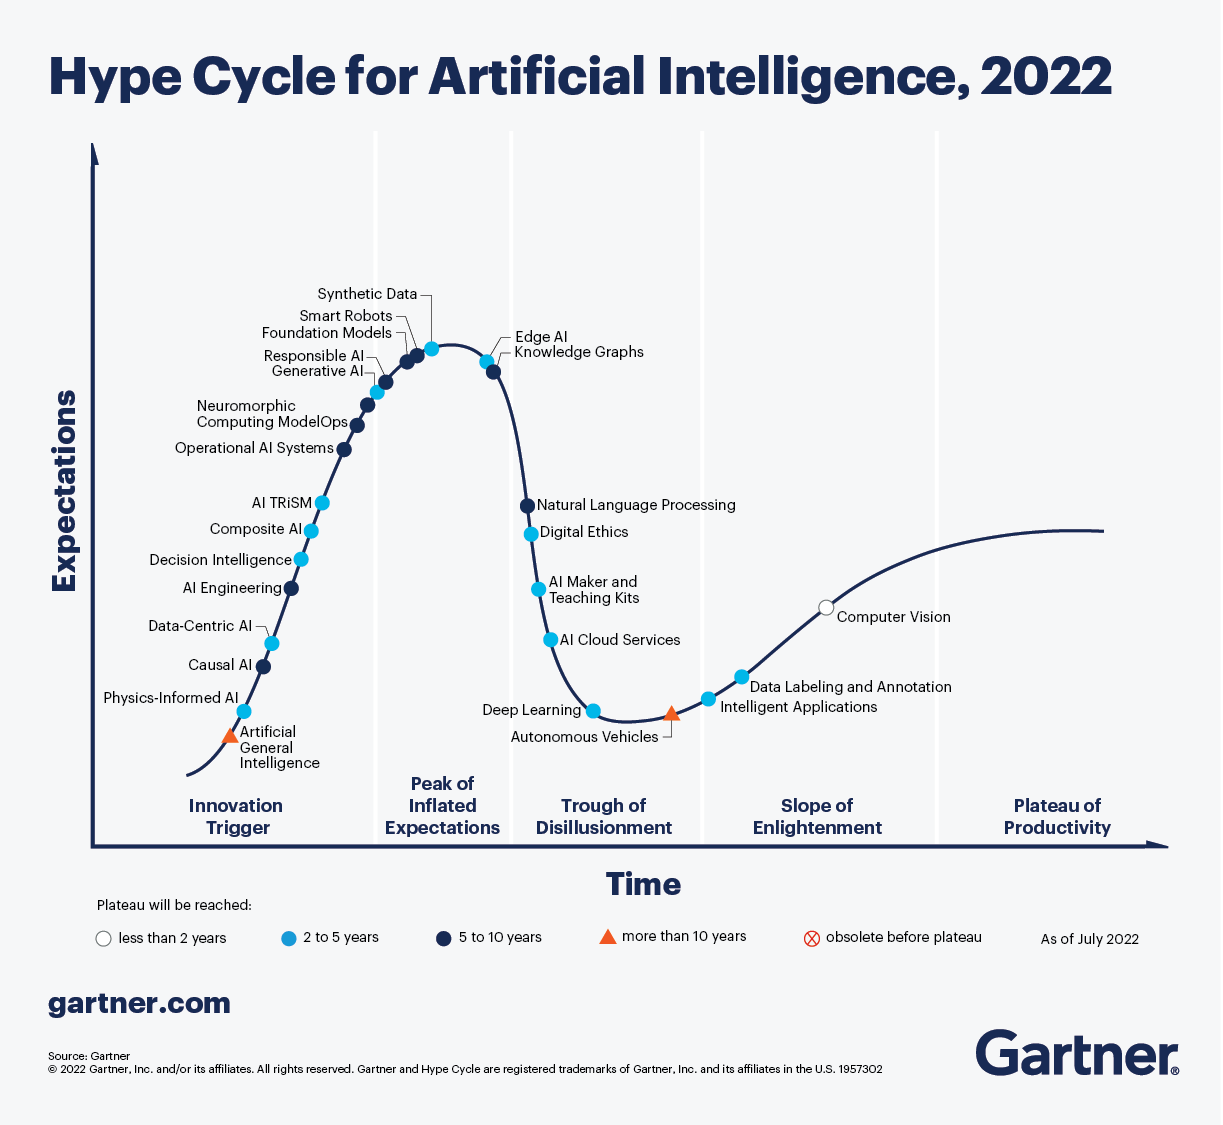

In [5]:
from IPython.display import Image
Image('/content/drive/MyDrive/projects/google_gen_ai_sample/contents/images/hype-cycle-for-artificial-intelligence-2022.png', width=700, height=600)


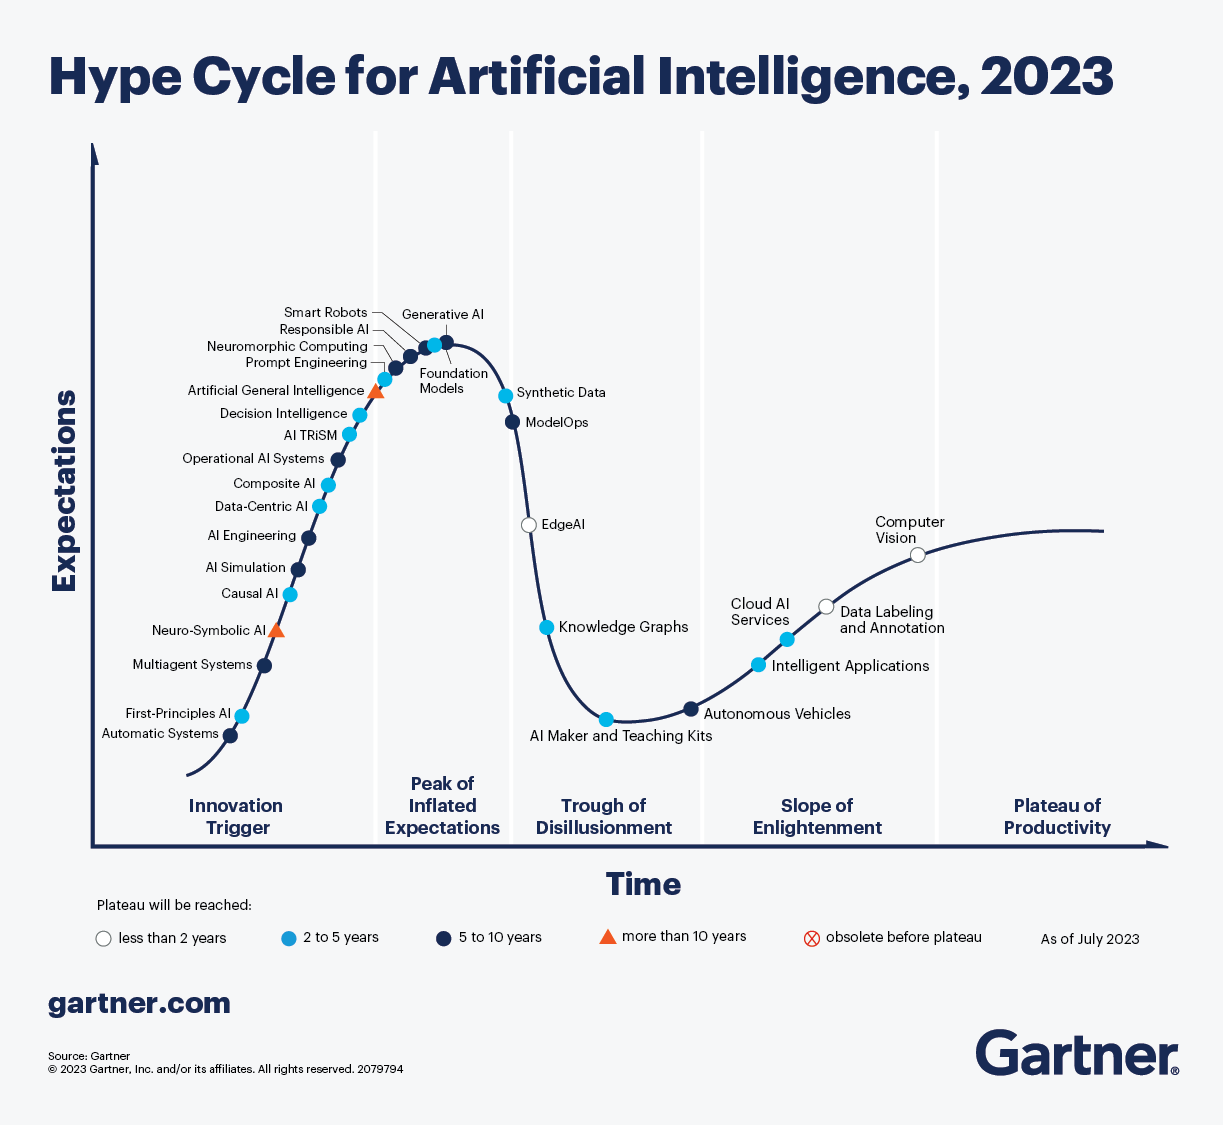

In [6]:
from IPython.display import Image
Image('/content/drive/MyDrive/projects/google_gen_ai_sample/contents/images/hype-cycle-for-artificial-intelligence-2023.png', width=700, height=600)

# Execute the example
## Set the environment on GCP Project
* Configure project information
  * Model name : LLM model name : https://cloud.google.com/vertex-ai/generative-ai/docs/learn/models
  * Project Id : prodect id in GCP
  * Region : region name in GCP

In [7]:
MODEL_NAME="gemini-1.5-flash"
PROJECT_ID="ai-hangsik"
REGION="asia-northeast3"

### Vertex AI initialization
Configure Vertex AI and access to the foundation model.

In [8]:
import vertexai
from vertexai.preview.generative_models import GenerativeModel, Part
import vertexai.preview.generative_models as generative_models

# Initalizate the current vertex AI execution environment.
vertexai.init(project=PROJECT_ID, location=REGION)

# Access to the generative model.
model = GenerativeModel(MODEL_NAME)

## Encoding function for multimodality

In [9]:
import base64

def get_encoded_content(location_type, location, mime_type ):
  """
  Get the encoded content object.

  location_type :
    The type of the location. ( local or GCS )
  location :
    The file location of the content.
  mime_type :
    The mime type of the content.

  Returns:
    The encoded content object.

  """

  content_obj = None

  if location_type == "local":
    with open(location, 'rb') as f:
      raw_obj = base64.b64encode(f.read()).decode('utf-8')
      content_obj = Part.from_data(data=base64.b64decode(raw_obj), mime_type=mime_type)

  elif location_type == "GCS":
        content_obj = Part.from_uri(location, mime_type=mime_type)
  else:
    raise ValueError("Invalid location type.")

  return content_obj

## Get responses from Gemini

In [10]:
def generate(content_obj1, content_obj2, query:str):
    """
    Generate a response from the model.

    content_obj :
      encoded object being analyzed in the process
    query :
      query to be sent to the model

    Returns:
      The generated response.

    """

    # Set model parameter : https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/send-multimodal-prompts#set_model_parameters
    generation_config = {
        "max_output_tokens": 8192,
        "temperature": 1,
        "top_p": 0.95,
    }

    # Configure satey setting : https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/configure-safety-attributes
    # Refer to the link to remove : https://cloud.google.com/vertex-ai/generative-ai/docs/multimodal/configure-safety-attributes#how_to_remove_automated_response_blocking_for_select_safety_attributes
    safety_settings = {
        generative_models.HarmCategory.HARM_CATEGORY_HATE_SPEECH: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        generative_models.HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        generative_models.HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
        generative_models.HarmCategory.HARM_CATEGORY_HARASSMENT: generative_models.HarmBlockThreshold.BLOCK_MEDIUM_AND_ABOVE,
    }

    responses = model.generate_content(
        [content_obj1,content_obj2, query],
        generation_config=generation_config,
        safety_settings=safety_settings,
        stream=False,
    )

    return responses.text

## Run the example

In [11]:

from time import perf_counter

t1_start = perf_counter()

# When using local storage for the file location.
location_type = "local"
mime_type = "image/png"

# 1st image
repository_root = "/content/drive/MyDrive/projects"
file_path = "/google_gen_ai_sample/contents/images/hype-cycle-for-artificial-intelligence-2022.png"
location = repository_root + file_path

content_obj1 = get_encoded_content(location_type, location, mime_type )

# 2nd image
repository_root = "/content/drive/MyDrive/projects"
file_path = "/google_gen_ai_sample/contents/images/hype-cycle-for-artificial-intelligence-2023.png"
location = repository_root + file_path

content_obj2 = get_encoded_content(location_type, location, mime_type )

# -----

prompt = """
You are a IT specialist to explain the trend of technologies.

1. Summarize what is the trend of technologies 2022, 2023 respectively.
2. Explain what is the trend of technologies in AI in detail with tables.
3. Explain what will be the trend in the upcomming years in AI technology trends.
"""

outcome = generate(content_obj1, content_obj2, prompt)

t1_end  = perf_counter()
print(f"Time : {t1_end - t1_start} seconds\n\n")

display(Markdown(outcome))


# When using Google Cloud Storage for the location type.

# location_type = "GCS"
# mime_type = "image/jpeg"
# repository_root = "gs://bucket_name"
# file_path = "/math.jpeg"
# location = repository_root + file_path

Time : 9.754724501999931 seconds




## AI Technology Trends: 2022 vs 2023

**1. Technology Trend Summary:**

* **2022:** The hype cycle for AI in 2022 highlighted the emergence of technologies like **Synthetic Data, Foundation Models, and Edge AI**.  These technologies were on the peak of inflated expectations, with other areas like **AI TRISM, AI-Composite AI, and Causal AI** still considered to be in the innovation trigger stage. 

* **2023:**  The 2023 hype cycle shows a shift in focus.  **Generative AI, Foundation Models, and ModelOps** are now at the peak of inflated expectations.  **Edge AI, Knowledge Graphs, and AI Maker and Teaching Kits** are moving towards the trough of disillusionment, indicating potential for increased adoption and practical application. 

**2. Detailed AI Technology Trends:**

| Technology Category | 2022 Position | 2023 Position | Trend | Explanation |
|---|---|---|---|---|
| **Foundation Models** |  Peak of Inflated Expectations | Peak of Inflated Expectations | Steady | Foundation models (e.g., GPT-3) are becoming increasingly powerful and versatile, leading to widespread adoption and experimentation in various domains. |
| **Generative AI** |  Not mentioned | Peak of Inflated Expectations | Rising |  The rise of generative AI models like DALL-E and ChatGPT has fueled immense excitement and investment in this technology. |
| **ModelOps** |  Peak of Inflated Expectations | Peak of Inflated Expectations | Steady |  Managing and deploying AI models effectively is becoming crucial, leading to increased interest in ModelOps tools and practices. |
| **Synthetic Data** | Peak of Inflated Expectations |  Trough of Disillusionment |  Declining |  While initially hyped, the practical implementation of synthetic data for training AI models is facing challenges and requiring further refinement. |
| **Edge AI** |  Slope of Enlightenment |  Trough of Disillusionment |  Declining |  Edge AI, despite its promise, is facing technical hurdles in implementing and scaling. |
| **AI TRISM** | Innovation Trigger |  Innovation Trigger |  Steady | This framework, emphasizing AI trust, risk, and security, is gaining attention as concerns about AI ethics and bias increase. |
| **AI-Composite AI** |  Innovation Trigger |  Innovation Trigger |  Steady |  The combination of different AI technologies to create more powerful and comprehensive solutions is gaining traction. |
| **Causal AI** | Innovation Trigger |  Innovation Trigger |  Steady | This field aims to understand and leverage causal relationships for better decision-making in AI systems, gaining importance for reliable and explainable AI. |

**3. Upcoming Trends in AI Technology:**

* **AI for Sustainability:**  AI will play a crucial role in addressing climate change and environmental challenges.  Expect to see innovations in AI-powered systems for resource management, renewable energy optimization, and environmental monitoring.
* **AI and the Metaverse:**  AI will be integral to the development and functionality of the metaverse, enabling realistic virtual environments, intelligent agents, and personalized experiences.
* **AI for Healthcare:**  AI will continue to revolutionize healthcare with advancements in diagnosis, treatment planning, drug discovery, and personalized medicine. 
* **Explainable AI (XAI):**  The demand for explainable AI models will increase as organizations need to understand the rationale behind AI decisions, fostering trust and ethical considerations.
* **AI for Social Good:**  AI will be used to address social issues like poverty, inequality, and education by developing AI-powered solutions for social impact. 

It's crucial to remember that these are just some of the many potential trends.  The field of AI is constantly evolving, and new technologies and applications are emerging rapidly.  Staying informed about these trends will be essential for navigating the future of AI and harnessing its transformative potential.
